# **Document Embedding with LLama 3**

The goal of this project is to embedd documents using Llama 3 and cluster the embeddings. The dataset consist of news articles and associated categories. To evaluate the embeddings, several cluster metrics and the cosine similarity are measured.

#**Preprocessing Steps**

This section outlines the steps that occur prior to the generation of embeddings. These steps are necessary to ensure the successful generation of the embeddings.

## **Install Required Packages**

In [1]:
#Install the 'transformers' library from Hugging Face
!pip install transformers

In [2]:
# Install the 'accelerate' package to speed up and optimize model training and inference in PyTorch.
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## **Import Statements**

In [3]:
#Initializes a WordNetLemmatizer for reducing words to their base forms
from nltk.stem import WordNetLemmatizer
#Initializes a PorterStemmer which reduces words to their root forms
from nltk.stem import PorterStemmer
#Imports the Natural Language Toolkit (NLTK) for text processing
import nltk
#Imports a list of stopwords for text processing
from nltk.corpus import stopwords
#Imports the pandas library for data manipulation and analysis
import pandas as pd
#Library for numerical computations
import numpy as np
#Imports the regular expression module for string pattern matching.
import re
#Imports a module for vreating dictionaries with default values
from collections import defaultdict
#Imports the time function for time related operations
from time import time
#Imports the metrics module from scikit-learn library for evaluating machine learning models
from sklearn import metrics
#Imports the TfidfVectorizer class for generating TF-IDF vectors from text data
from sklearn.feature_extraction.text import TfidfVectorizer
#Imports TSNE class for dimensionality reduction
from sklearn.manifold import TSNE
#Imports the pyplot module for creating visualizations
import matplotlib.pyplot as plt
#Imports the seaborn library for statistical data visualization
import seaborn as sns
#Imports KMeans class for K-means clustering
from sklearn.cluster import KMeans
#Imports the cosine_similarity for computing cosine similarity between pairs of samples
from sklearn.metrics.pairwise import cosine_similarity
#Imports Counter class for counting hashable objects
from collections import Counter
#Imports silhouette_samples and silhouette_score for measuring the quality of clustering
from sklearn.metrics import silhouette_samples, silhouette_score
#Imports the cm module for handling colormaps
import matplotlib.cm as cm
#Imports the drive module for accessing Google Drive files in Google Colab environment.
from google.colab import drive
#Import the 'transformers' library, which provides state-of-the-art pre-trained models for natural language processing.
import transformers
#Import the PyTorch library, which is used for tensor computations and deep learning
import torch
#Import the 'login' function from the 'huggingface_hub' module to authenticate with the Hugging Face Hub.
from huggingface_hub import login
#Import the AutoModel and AutoTokenizer classes from the transformers library for loading pre-trained models and tokenizers
from transformers import AutoModel, AutoTokenizer
# Import the LabelEncoder class to convert categorical variables into numeric values
from sklearn.preprocessing import LabelEncoder
#Imports PCA class for dimensionality reduction
from sklearn.decomposition import PCA
#Import 'getpass' module to securely prompt for passwords
import getpass

## **Download Statements**

In [4]:
#Downloads the WordNet dataset for the NLTK library for using certain features like lemmatization
nltk.download('wordnet')
#Downloads the stopwords dataset for the NLTK library, which contains common words
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Load Model**

To use the Llama model from Hugging Face, you need a token to log in. This can be obtained from the Hugging Face website. Once you have the token, you can log in here and use the model.

In [5]:
#Prompt for huggingface token
huggingFaceToken = getpass.getpass("Hugging Face Token: ")

login(huggingFaceToken)

Hugging Face Token: ··········
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Load the Llama 3 model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Load the Llama 3 model and tokenizer
model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## **Data Preprocessing**

### Dataset One

The dataset consists of 252 different news articles and eight categories. The dataset is stored in the path variable.

In [8]:
#Mounts the Google Drive at ("/content/drive") in the Google Colab enviornment
drive.mount("/content/drive")
path = "/content/drive/MyDrive/Implementation/Dataset/NewsTwo.csv"

Mounted at /content/drive


In [9]:
#Read a CSV file into a pandas DataFrame object using the latin1 encoding
news_df = pd.read_csv(path,encoding='latin1')

Preprocessing consists of several steps. First, the data is converted into lowercase and stored in a new DataFrame object.Then the functions for lemmatization, stemming, removal of stop words and removal of special characters are implemented

In [10]:
#Save the original 'News' column for comparison later
news_df['Original_News'] = news_df['News']
news_df['Preprocessed_News'] = news_df['News']

#Convert to lowercase
news_df['Preprocessed_News'] = news_df['Preprocessed_News'].str.lower()

#Setting the language setting for the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)


All preprocessing steps are combined in one function. In some cases it is better to use lemmatization and stemming. In some other cases it is not suitable.
In this case, it is better to not use these features

In [11]:
#Text pre-processing function
def preprocess_text(text):
    #text = remove_special_characters(text)
    #text = remove_stopwords(text)
    #text = lemmatize_text(text) #You can choose whether to apply lemmatization
    #text = stem_text(text)  #You can choose whether to apply stemming
    return text

Now the preprocessing steps are applied to the dataset

In [12]:
#Apply preprocessing to the documents
news_df['Preprocessed_News'] = news_df['Preprocessed_News'].apply(preprocess_text)

#Check for missing values ​​and handle them
if news_df.isnull().values.any():
    news_df.dropna(inplace=True)

#Extract the text data and associated categories from the filtered DataFrame
text_data = news_df['Preprocessed_News']
labels = news_df['Category']
print(f"{len(text_data)} documents ")

#Calculate unique labels and their counts and store the number of categories in "true_k"
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

#Display the total number of documents an categories
print(f"{len(news_df)} documents - {true_k} categories")

252 documents 
252 documents - 8 categories


Compare the news article before and after preprocessing

In [13]:
#Create a new DataFrame to compare original and preprocessed news articles
comparison_df = news_df[['Original_News', 'Preprocessed_News']]
comparison_df.head(10)

,Original_News,Preprocessed_News
0,The IMF now expects China's economy to grow by...,the imf now expects china's economy to grow by...
1,Manufacturing activity in the Eurozone has dec...,manufacturing activity in the eurozone has dec...
2,Continued disruptions in the global supply cha...,continued disruptions in the global supply cha...
3,Concerns about food security remain high due t...,concerns about food security remain high due t...
4,"While some central banks, like the US Federal ...","while some central banks, like the us federal ..."
5,Bangladeshi workers abroad continue to send st...,bangladeshi workers abroad continue to send st...
6,The Centre for Economics and Business Research...,the centre for economics and business research...
7,Bangladesh has maintained macroeconomic stabil...,bangladesh has maintained macroeconomic stabil...
8,Government investments in infrastructure proje...,government investments in infrastructure proje...
9,"he US unemployment rate has dropped to 3.5%, i...","he us unemployment rate has dropped to 3.5%, i..."


### Dataset Two

The dataset consists of 50000 different news articles and ten categories.

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# CSV-Datei laden
df_two = pd.read_csv("/content/drive/MyDrive/Implementation/Dataset/NewsCategorizer.csv")

news_two_df = df_two.drop(['headline','links','keywords'], axis = 1)

Preprocessing consists of several steps. First, the data is converted into lowercase and stored in a new DataFrame object.Then the functions for lemmatization, stemming, removal of stop words and removal of special characters are implemented

In [ ]:
#Convert to lowercase
news_two_df['short_description'] = news_two_df['short_description'].str.lower()

#Setting the language setting for the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)


All preprocessing steps are combined in one function. In some cases it is better to use lemmatization and stemming. In some other cases it is not suitable.
In this case, it is better to not use these features

In [ ]:
#Text pre-processing function
def preprocess_text(text):
    #text = remove_special_characters(text)
    #text = remove_stopwords(text)
    #text = lemmatize_text(text) #You can choose whether to apply lemmatization
    #text = stem_text(text)  #You can choose whether to apply stemming
    return text

Now the preprocessing steps are applied to the dataset

In [ ]:
#Apply preprocessing to the documents
news_two_df['short_description'] = news_two_df['short_description'].apply(preprocess_text)

#Check for missing values ​​and handle them
if news_two_df.isnull().values.any():
    news_two_df.dropna(inplace=True)

#Extract the text data and associated categories from the filtered DataFrame
text_data_two = news_two_df['short_description']
labels_two = news_two_df['category']
print(f"{len(text_data_two)} documents ")

#Calculate unique labels and their counts and store the number of categories in "true_k"
unique_labels_two, category_sizes_two = np.unique(labels_two, return_counts=True)
true_k_two = unique_labels_two.shape[0]

#Display the total number of documents an categories
print(f"{len(news_two_df)} documents - {true_k_two} categories")

50000 documents 
50000 documents - 10 categories


Compare the news article before and after preprocessing

In [ ]:
#Save the original 'News' column for comparison later
news_two_df['Original_News'] = df_two['short_description']
news_two_df['Preprocessed_News'] = news_two_df['short_description']
news_two_df['News'] = news_two_df['short_description']

In [ ]:
news_two_df['Category'] = news_two_df['category']

In [ ]:
#Create a new DataFrame to compare original and preprocessed news articles
comparison_df_two = news_two_df[['Original_News', 'Preprocessed_News']]
comparison_df_two.head(10)

,Original_News,Preprocessed_News
0,Resting is part of training. I've confirmed wh...,resting is part of training. i've confirmed wh...
1,Think of talking to yourself as a tool to coac...,think of talking to yourself as a tool to coac...
2,The clock is ticking for the United States to ...,the clock is ticking for the united states to ...
3,"If you want to be busy, keep trying to be perf...","if you want to be busy, keep trying to be perf..."
4,"First, the bad news: Soda bread, corned beef a...","first, the bad news: soda bread, corned beef a..."
5,"By Carey Moss for YouBeauty.com Love rom-coms,...","by carey moss for youbeauty.com love rom-coms,..."
6,The nation in general scored a 66.2 in 2011 on...,the nation in general scored a 66.2 in 2011 on...
7,It's also worth remembering that if the water ...,it's also worth remembering that if the water ...
8,"If you look at our culture's eating behavior, ...","if you look at our culture's eating behavior, ..."
9,"François-Marie Arouet, 18th century French aut...","françois-marie arouet, 18th century french aut..."


### Dataset Three

The dataset consists of around 100000 different news articles and eight categories.

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CSV-Datei laden
df_three = pd.read_csv("/content/drive/MyDrive/Implementation/Dataset/NewNews.csv",delimiter=";")

news_three_df = df_three.drop(['link','domain','published_date','lang'], axis = 1)

Preprocessing consists of several steps. First, the data is converted into lowercase and stored in a new DataFrame object.Then the functions for lemmatization, stemming, removal of stop words and removal of special characters are implemented

In [ ]:
#Convert to lowercase
news_three_df['title'] = news_three_df['title'].str.lower()

#news_three_df = news_three_df.groupby('topic').apply(lambda x: x.sample(min(len(x), 1000))).reset_index(drop=True)

#Setting the language setting for the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)


All preprocessing steps are combined in one function. In some cases it is better to use lemmatization and stemming. In some other cases it is not suitable.
In this case, it is better to not use these features

In [ ]:
#Text pre-processing function
def preprocess_text(text):
    #text = remove_special_characters(text)
    #text = remove_stopwords(text)
    #text = lemmatize_text(text) #You can choose whether to apply lemmatization
    #text = stem_text(text)  #You can choose whether to apply stemming
    return text

Now the preprocessing steps are applied to the dataset

In [ ]:
#Apply preprocessing to the documents
news_three_df['title'] = news_three_df['title'].apply(preprocess_text)

#Check for missing values ​​and handle them
if news_three_df.isnull().values.any():
    news_three_df.dropna(inplace=True)

#Extract the text data and associated categories from the filtered DataFrame
text_data_three = news_three_df['title']
labels_three = news_three_df['topic']
print(f"{len(text_data_three)} documents ")

#Calculate unique labels and their counts and store the number of categories in "true_k"
unique_labels_three, category_sizes_three = np.unique(labels_three, return_counts=True)
true_k_three = unique_labels_three.shape[0]

#Display the total number of documents an categories
print(f"{len(news_three_df)} documents - {true_k_three} categories")

108774 documents 
108774 documents - 8 categories


Compare the news article before and after preprocessing

In [ ]:
#Save the original 'News' column for comparison later
news_three_df['Original_News'] = df_three['title']
news_three_df['Preprocessed_News'] = news_three_df['title']
news_three_df['News'] = news_three_df['title']

In [ ]:
news_three_df['Category'] = news_three_df['topic']

In [ ]:
#Create a new DataFrame to compare original and preprocessed news articles
comparison_df_three = news_three_df[['Original_News', 'Preprocessed_News']]
comparison_df_three.head(10)

,Original_News,Preprocessed_News
0,A closer look at water-splitting's solar fuel ...,a closer look at water-splitting's solar fuel ...
1,An irresistible scent makes locusts swarm stud...,an irresistible scent makes locusts swarm stud...
2,Artificial intelligence warning: AI will know ...,artificial intelligence warning: ai will know ...
3,Glaciers Could Have Sculpted Mars Valleys: Study,glaciers could have sculpted mars valleys: study
4,Perseid meteor shower 2020: What time and how ...,perseid meteor shower 2020: what time and how ...
5,NASA Releases In-Depth Map of Beirut Explosion...,nasa releases in-depth map of beirut explosion...
6,"SpaceX, NASA Demo-2 Rocket Launch Set for Satu...","spacex, nasa demo-2 rocket launch set for satu..."
7,Orbital space tourism set for rebirth in 2021,orbital space tourism set for rebirth in 2021
8,Greenland's melting ice sheet has 'passed the ...,greenland's melting ice sheet has 'passed the ...
9,NASA invites engineering students to help harv...,nasa invites engineering students to help harv...


#**Llama 3 Embedding With First Dataset**

## **Llama 3**

With this function we get the Llama 3 embedding of a document. The average of the last layer hidden states over all tokens in the input sequence is calculated to obtain a single vector representation of the entire sequence.




In [14]:
def get_mean_embeddings(texts):
    #Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=False, truncation=True)

    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    #Get the model's outputs
    with torch.no_grad():
        outputs = model(**inputs)
    #Return the mean-pooled embeddings as a NumPy array
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

This code calculates the Llama 3 embeddings for each text in the 'News' column of the news_df DataFrame and stores the resulting embeddings in a NumPy array called np_embeddings.



In [15]:
#Create an empty list to store the embeddings
embeddings = []

#Iterate over each text in the 'News' column of the DataFrame and compute its Llama embedding
for text in news_df['News']:
    #Call the function 'get_mean_embedding' to get the Llama embedding for the current text
    embedding = get_mean_embeddings(text)

    #Append the embedding to the list of embeddings
    embeddings.append(embedding)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [16]:
np_embeddings = np.array(embeddings)

Print the shape of the embeddings. The first number in the tuple represents the number of documents and the second number the hidden dimensions

In [17]:
print(np_embeddings.shape)

(252, 4096)


Llama 3 embeddings ​​of the first document.

In [18]:
#Display the Embeddings of the first document
print(text_data[0])
print(np_embeddings[0])

the imf now expects china's economy to grow by 5.4% this year, higher than previous estimates. this reflects china's shift away from its zero-covid policy and increased government stimulus.
[-0.1691306  -1.4899757  -1.3598232  ... -0.4844058  -0.26291877
 -0.37796527]


Comparison between two similar news article

In [19]:
print("First news article:")
print(text_data[40])
print("Second news article:")
print(text_data[216])
print("Embedding of first document:")
print(np_embeddings[40])
print("Embedding of second document:")
print(np_embeddings[216])

First news article:
conor mcgregor, the ufc's biggest star, has announced his return to the octagon in 2024. mcgregor has been on the sidelines since suffering a leg injury in july 2021, but he is now fully recovered and ready to get back in the cage. his opponent and fight date are yet to be determined, but mcgregor's return is sure to generate excitement among mma fans.
Second news article:
the highly anticipated rubber match between ufc stars dustin poirier and conor mcgregor is finally happening, promising an electrifying showdown.
Embedding of first document:
[ 0.5805314  -1.2637008  -2.7128513  ... -1.0174932  -0.06545576
  0.5298187 ]
Embedding of second document:
[ 0.7168279   1.0347286  -0.93032473 ... -1.3988272   0.8697389
 -0.57372123]


In [20]:
print("First news article:")
print(text_data[138])
print("Second news article:")
print(text_data[139])
print("Embedding of first document:")
print(np_embeddings[138])
print("Embedding of second document:")
print(np_embeddings[139])

First news article:
the ai & big data expo, which took place in london on december 19-20, 2023, brought together experts from around the world to discuss the latest advances in artificial intelligence and big data. one of the key themes of the expo was how to use ai to get the most value out of real-time data streams.
Second news article:
the ai & big data expo also focused on the ethical implications of ai and big data. one of the sessions at the expo discussed the importance of using data for good, such as to improve healthcare and education.
Embedding of first document:
[ 0.21672821  0.33879066 -0.27807686 ... -0.61986923 -1.5507232
  0.3034628 ]
Embedding of second document:
[ 0.654216    0.79952896  0.15601434 ... -0.11153004 -0.9916558
 -0.01113211]


Get the cosine similarity for these embeddings. Cosine similarity measures the cosine of the angle between vectors in a multi-dimensional space, representing their orientation. It ranges from -1 to 1, where 1 indicates that the vectors are identical in direction, 0 means they are orthogonal, and -1 means they are diametrically opposed.

Cosine similarity between sports article

In [21]:
#Cosine Similarity
cos_sim = cosine_similarity([np_embeddings[40]], [np_embeddings[216]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.7530571222305298


Cosine similarity between AI article

In [22]:
#Cosine Similarity
cos_sim = cosine_similarity([np_embeddings[138]], [np_embeddings[139]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.8423562049865723


Cosine similarity between sports and AI article

In [23]:
#Cosine Similarity
cos_sim = cosine_similarity([np_embeddings[139]], [np_embeddings[216]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.3814685344696045


## **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [24]:
#Initialize and train KMeans clustering algorithm
kmeans = KMeans(
    n_clusters=true_k,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(np_embeddings)



Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, t-SNE (t-Distributed Stochastic Neighbor Embedding) is used

In [25]:
#Reduce dimensionality of embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42,init='random')
embeddings_2d = tsne.fit_transform(np_embeddings)

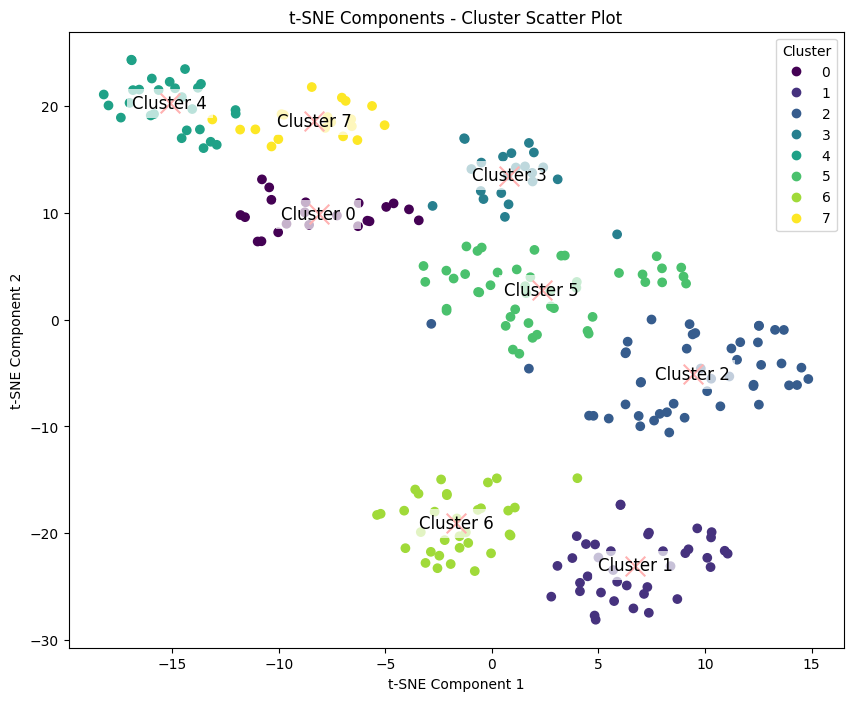

True number of documents in each category according to the class labels: [27 35 39 36 27 32 24 32]
Number of elements assigned to each cluster: [21 38 46 22 27 46 33 19]


In [26]:
#Calculate the number of elements assigned to each cluster
cluster_ids_llama, cluster_sizes_llama = np.unique(kmeans.labels_, return_counts=True)

#Visualize the clusters using the t-SNE reduced data
plt.figure(figsize=(10, 8)) #10,8 normal
cluster_labels = kmeans.labels_

scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k):
    plt.text(embeddings_2d[cluster_labels == label, 0].mean(), embeddings_2d[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d[cluster_labels == label, 0].mean(), embeddings_2d[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_llama}")


## **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters

In [27]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=1):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


Applies the fit_and_evaluate function and visualizes it

clustering done in 5.23 ± 0.00 s 
Homogeneity: 0.731 ± 0.000
Completeness: 0.749 ± 0.000
V-measure: 0.740 ± 0.000
Adjusted Rand-Index: 0.613 ± 0.000
Silhouette Coefficient: 0.119 ± 0.000


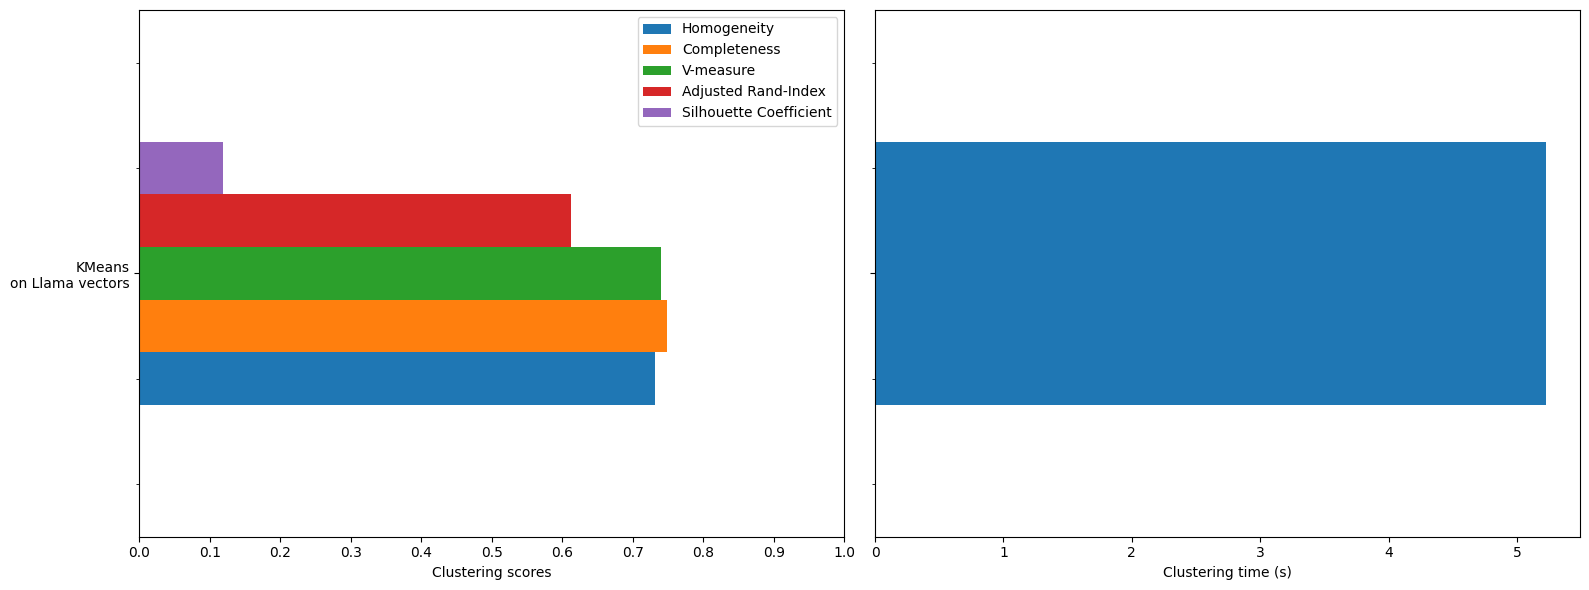

In [28]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans, np_embeddings, name="KMeans\non Llama vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

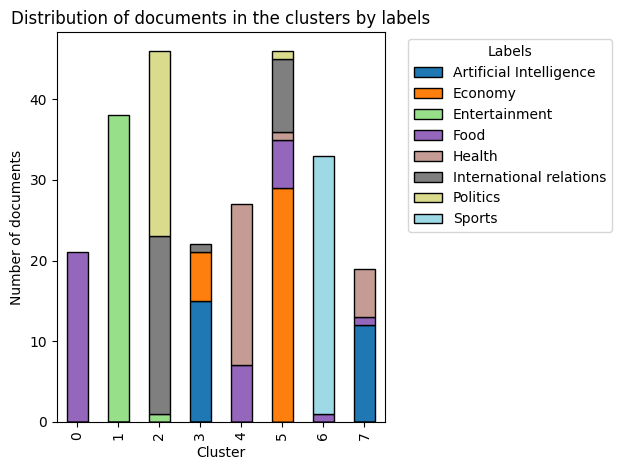

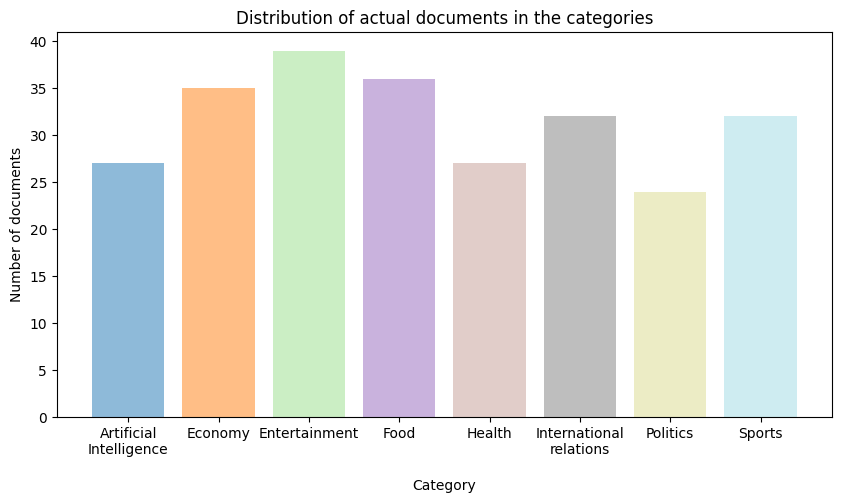


Distribution of documents in the clusters according to labels:
true_label  Artificial Intelligence   Economy  Entertainment  Food  Health  \
cluster                                                                      
0                                  0        0              0    21       0   
1                                  0        0             38     0       0   
2                                  0        0              1     0       0   
3                                 15        6              0     0       0   
4                                  0        0              0     7      20   
5                                  0       29              0     6       1   
6                                  0        0              0     1       0   
7                                 12        0              0     1       6   

true_label  International relations  Politics  Sports  
cluster                                                
0                                 0        

In [29]:
x_labels = news_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes)), category_sizes, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_llama):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [30]:
#True labels
categories = news_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_df[news_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the Llama 3 vectors of the documents in the current category.
        category_llama = np_embeddings[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_llama)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for Economy: 0.6286057416130515
Average Cosine Similarity for Health: 0.6297480047937811
Average Cosine Similarity for Sports: 0.6064421130764869
Average Cosine Similarity for Entertainment: 0.5384290852205634
Average Cosine Similarity for Politics: 0.5966979317043138
Average Cosine Similarity for International relations: 0.6013958838678175
Average Cosine Similarity for Food: 0.5179231189546131
Average Cosine Similarity for Artificial Intelligence : 0.6067897872707443


Get the cosine siimilarity between categories

In [31]:
#Get the unique categories
categories = news_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_df[news_df['Category'] == category1].index
    category1_vector = np_embeddings[indices1]

    #Extract the documents in the second category
    indices2 = news_df[news_df['Category'] == category2].index
    category2_vector = np_embeddings[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between Economy and Health: 0.40217119455337524
Average Cosine Similarity between Sports and Entertainment: 0.4504601061344147
Average Cosine Similarity between Politics and International relations: 0.5573122501373291
Average Cosine Similarity between Food and Artificial Intelligence : 0.4171893000602722


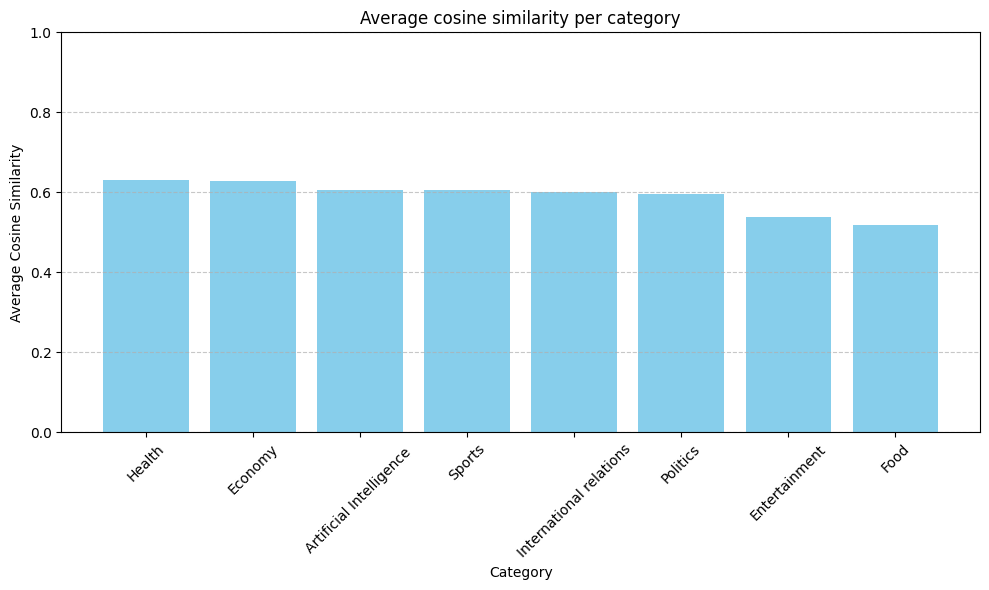

In [32]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  #Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [33]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, np_embeddings)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

Here we create a heatmap which visually represents the top categories for each cluster

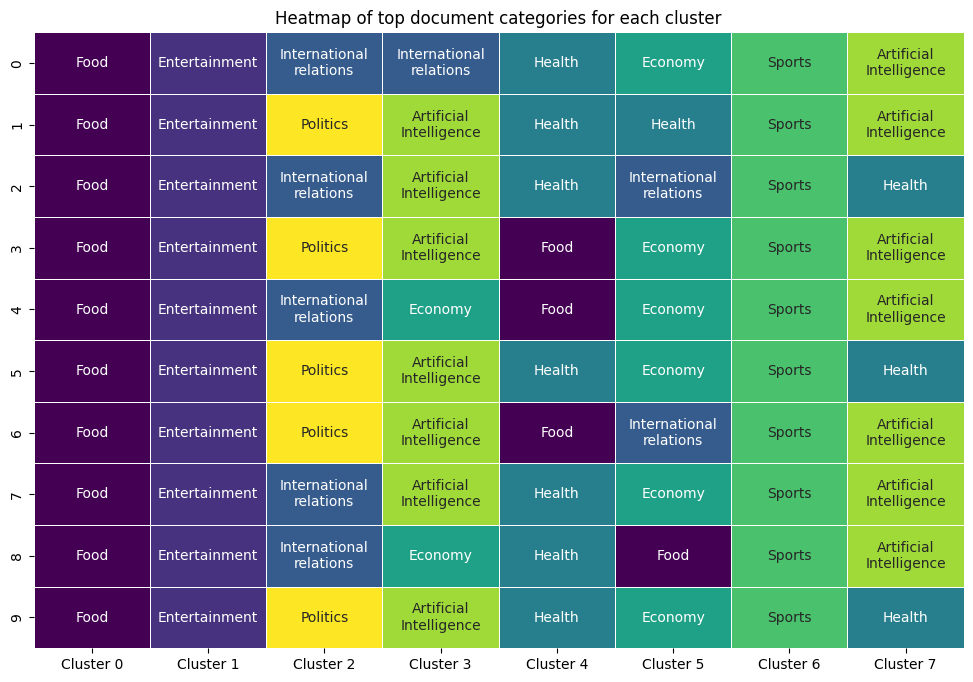

In [34]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)


#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k)])
heatmap_df = heatmap_df.T  # Transpose for better visualization

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()


#**Llama 3 Embedding With Second Dataset**

## **Llama 3**

With this function we get the Llama 3 embedding of a document. The average of the last layer hidden states over all tokens in the input sequence is calculated to obtain a single vector representation of the entire sequence.




In [ ]:
def get_mean_embeddings(texts):
    #Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=False, truncation=True)

    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    #Get the model's outputs
    with torch.no_grad():
        outputs = model(**inputs)
    #Return the mean-pooled embeddings as a NumPy array
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

This code calculates the Llama 3 embeddings for each text in the 'News' column of the news_df DataFrame and stores the resulting embeddings in a NumPy array called embeddings_two.



In [ ]:
#Create an empty list to store the embeddings
embeddings_two = []

#Iterate over each text in the 'News' column of the DataFrame and compute its Llama embedding
for text in news_two_df['News']:
    #Call the function 'get_mean_embedding' to get the Llama embedding for the current text
    embedding = get_mean_embeddings(text)

    #Append the embedding to the list of embeddings
    embeddings_two.append(embedding)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
embeddings_two = np.array(embeddings_two)

Print the shape of the embeddings. The first number in the tuple represents the number of documents and the second number the hidden dimensions

In [ ]:
print(embeddings_two.shape)

(50000, 4096)


Llama 3 embeddings ​​of the first document.

In [ ]:
#Display the Embeddings of the first document
print(text_data_two[0])
print(embeddings_two[0])

resting is part of training. i've confirmed what i sort of already knew: i'm not built for running streaks. i'm built for hard workouts three to five days a week with lots of cross training, physical therapy and foam rolling. but i've also confirmed that i'm stubborn with myself.
[-1.129145    0.6552104   1.3529215  ... -0.94318867  1.8816837
  1.7945869 ]


Comparison between similar news article

In [ ]:
print("First news article:")
print(text_data_two[49085])
print("Second news article:")
print(text_data_two[48331])
print("Embedding of first document:")
print(embeddings_two[49085])
print("Embedding of second document:")
print(embeddings_two[48331])

First news article:
the nba would not allow griffin to use the car of his choice for the 2011 dunk contest.
Second news article:
an nba team is a business, but it also carries the imagery of representing that city.  sports and athletes can provide opportunities for positive role modeling and influencing attitudes -- when turned negative, the effects ripple.
Embedding of first document:
[-1.7355282  -1.1411133  -0.26490462 ... -0.44173965  0.4270552
  1.1439122 ]
Embedding of second document:
[-1.1866876   0.10089014 -1.7388463  ...  0.04735758  2.5540755
 -0.46615574]


In [ ]:
print("First news article:")
print(text_data_two[34782])
print("Second news article:")
print(text_data_two[34767])
print("Embedding of first document:")
print(embeddings_two[34782])
print("Embedding of second document:")
print(embeddings_two[34767])

First news article:
pizza, hamburgers, hot dogs and oreos. we love these foods. it's mind-blowing the millions and billions of gallons and pounds we eat of each every year.
Second news article:
you say you love pizza? prove it.
Embedding of first document:
[-0.47724372 -0.86055285  1.7584207  ... -1.6246253   2.0863724
  0.6005677 ]
Embedding of second document:
[-0.22275968 -0.2761049   2.4368966  ... -0.55768245  2.0946822
  0.8174804 ]


Get the cosine similarity for these embeddings. Cosine similarity measures the cosine of the angle between vectors in a multi-dimensional space, representing their orientation. It ranges from -1 to 1, where 1 indicates that the vectors are identical in direction, 0 means they are orthogonal, and -1 means they are diametrically opposed.

Cosine similarity between sports article

In [ ]:
#Cosine Similarity
cos_sim = cosine_similarity([embeddings_two[49085]], [embeddings_two[48331]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.6871603727340698


Cosine similarity between food article

In [ ]:
#Cosine Similarity
cos_sim = cosine_similarity([embeddings_two[34782]], [embeddings_two[34767]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.6914219856262207


Cosine similarity between sports and food article

In [ ]:
#Cosine Similarity
cos_sim = cosine_similarity([embeddings_two[49085]], [embeddings_two[34782]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.5813429355621338


## **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans_two = KMeans(
    n_clusters=true_k_two,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(embeddings_two)

Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, SVD (Singular Value Decomposition) is used, cause it need less time and computing power.

In [ ]:
#Reducing the dimensions of the embeddings with PCA.
pca = PCA(n_components=2)
embeddings_2d_two = pca.fit_transform(embeddings_two)

In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_llama, cluster_sizes_llama = np.unique(kmeans_two.labels_, return_counts=True)

#Visualize the clusters using the PCA reduced data
plt.figure(figsize=(25, 20))
cluster_labels = kmeans_two.labels_

scatter = plt.scatter(embeddings_2d_two[:, 0], embeddings_2d_two[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k_two):
    plt.text(embeddings_2d_two[cluster_labels == label, 0].mean(), embeddings_2d_two[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d_two[cluster_labels == label, 0].mean(), embeddings_2d_two[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes_two}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_llama}")


Output hidden; open in https://colab.research.google.com to view.

## **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters


In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=1):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels_two, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels_two, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels_two, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels_two, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


Applies the fit_and_evaluate function and visualizes it

clustering done in 678.87 ± 0.00 s 
Homogeneity: 0.311 ± 0.000
Completeness: 0.314 ± 0.000
V-measure: 0.313 ± 0.000
Adjusted Rand-Index: 0.208 ± 0.000
Silhouette Coefficient: 0.050 ± 0.000


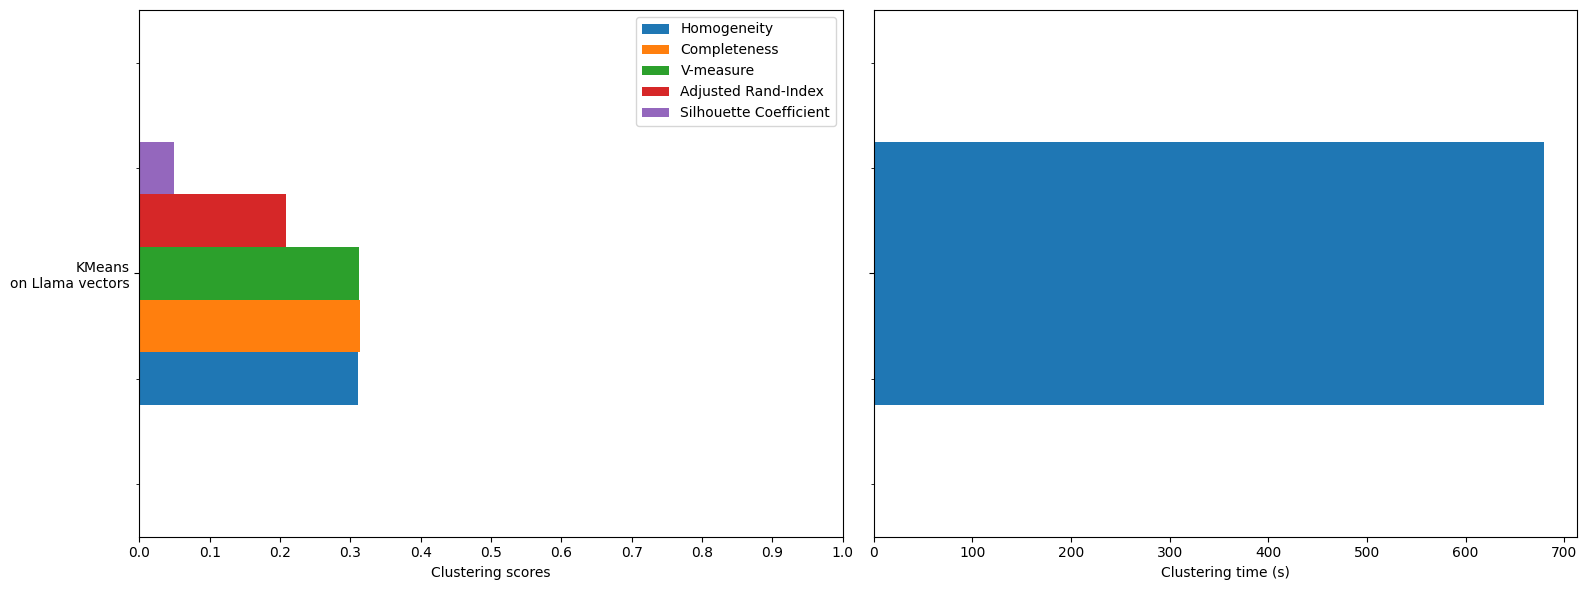

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans_two, embeddings_two, name="KMeans\non Llama vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))
#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

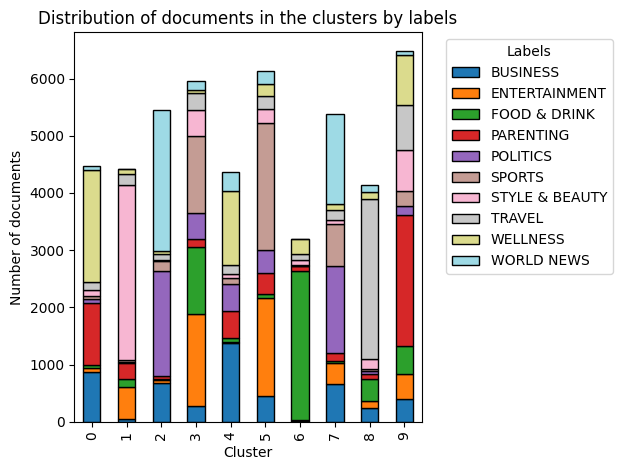

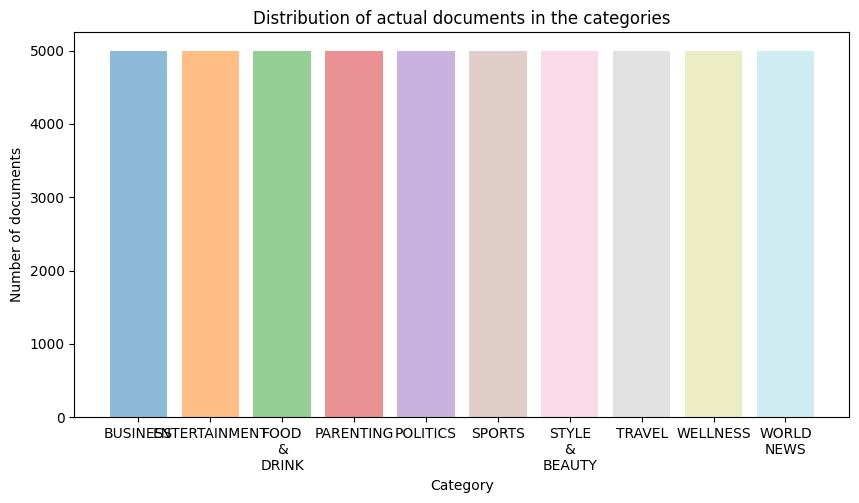


Distribution of documents in the clusters according to labels:
true_label  BUSINESS  ENTERTAINMENT  FOOD & DRINK  PARENTING  POLITICS  \
cluster                                                                  
0                866             81            47       1082        71   
1                 47            568           142        267        17   
2                683             52             6         54      1850   
3                275           1614          1162        140       452   
4               1372             25            60        472       485   
5                444           1728            54        370       408   
6                 21              6          2614         82         5   
7                653            372            30        152      1516   
8                237            126           388         93        43   
9                402            428           497       2288       153   

true_label  SPORTS  STYLE & BEAUTY  TRAVEL  WEL

In [ ]:
x_labels = news_two_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_two_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes_two = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes_two)), category_sizes_two, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes_two)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_llama):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes_two):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_two_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_two_df[news_two_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the Llama 3 vectors of the documents in the current category.
        category_llama = embeddings_two[indices]
        #Calculate the cosine similarity matrix for these documents
        category_sim_matrix = cosine_similarity(category_llama)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for WELLNESS: 0.5852218843768754
Average Cosine Similarity for POLITICS: 0.6258606121224245
Average Cosine Similarity for ENTERTAINMENT: 0.6295910782156431
Average Cosine Similarity for TRAVEL: 0.612865573114623
Average Cosine Similarity for STYLE & BEAUTY: 0.657825325065013
Average Cosine Similarity for PARENTING: 0.6241373074614923
Average Cosine Similarity for FOOD & DRINK: 0.6278189637927586
Average Cosine Similarity for WORLD NEWS: 0.6117859171834367
Average Cosine Similarity for BUSINESS: 0.5775611122224444
Average Cosine Similarity for SPORTS: 0.6206882976595319


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_two_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_two_df[news_two_df['Category'] == category1].index
    category1_vector = embeddings_two[indices1]

    #Extract the documents in the second category
    indices2 = news_two_df[news_two_df['Category'] == category2].index
    category2_vector = embeddings_two[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between WELLNESS and POLITICS: 0.5265481472015381
Average Cosine Similarity between ENTERTAINMENT and TRAVEL: 0.5649622678756714
Average Cosine Similarity between STYLE & BEAUTY and PARENTING: 0.5905715823173523
Average Cosine Similarity between FOOD & DRINK and WORLD NEWS: 0.4911794662475586
Average Cosine Similarity between BUSINESS and SPORTS: 0.5422466397285461


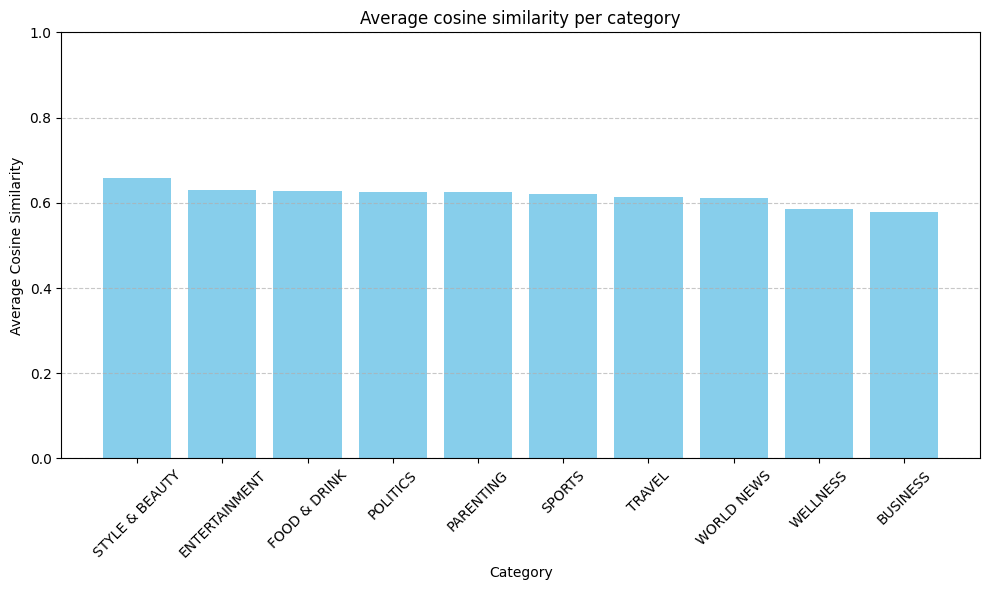

In [ ]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  #Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10


#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k_two):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans_two.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, embeddings_two)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

 Here we create a heatmap which visually represents the top categories for each cluster based on the cosine similarity. The documents are sorted in descending order according to their similarity to the cluster center.

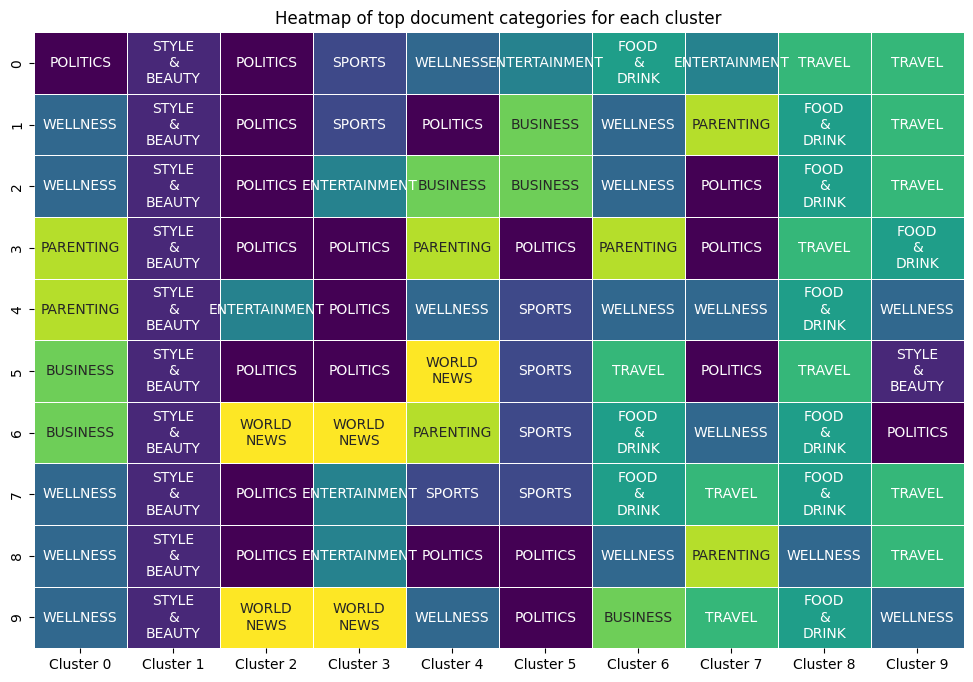

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_two_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)

#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k_two)])
heatmap_df = heatmap_df.T  # Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()


#**Llama 3 Embedding With Third Dataset**

## **Llama 3**

With this function we get the Llama 3 embedding of a document. The average of the last layer hidden states over all tokens in the input sequence is calculated to obtain a single vector representation of the entire sequence.




In [ ]:
def get_mean_embeddings(texts):
    #Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=False, truncation=True)

    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    #Get the model's outputs
    with torch.no_grad():
        outputs = model(**inputs)
    #Return the mean-pooled embeddings as a NumPy array
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

This code calculates the Llama 3 embeddings for each text in the 'News' column of the news_df DataFrame and stores the resulting embeddings in a NumPy array called embeddings_three.



In [ ]:
#Create an empty list to store the embeddings
embeddings_three = []

#Iterate over each text in the 'News' column of the DataFrame and compute its Llama embedding
for text in news_three_df['News']:
    #Call the function 'get_mean_embedding' to get the Llama embedding for the current text
    embedding = get_mean_embeddings(text)

    #Append the embedding to the list of embeddings
    embeddings_three.append(embedding)

In [ ]:
embeddings_three = np.array(embeddings_three)

Print the shape of the embeddings. The first number in the tuple represents the number of documents and the second number the hidden dimensions

In [ ]:
print(embeddings_three.shape)

(108774, 4096)


Llama 3 embeddings ​​of the first document.

In [ ]:
#Display the Embeddings of the first document
print(text_data_three[0])
print(embeddings_three[0])

a closer look at water-splitting's solar fuel potential
[-0.7641999   0.4641455   1.9747442  ... -1.9450164   0.70139205
  0.01956286]


Comparison between similar news article

In [ ]:
print("First news article:")
print(text_data_three[9])
print("Second news article:")
print(text_data_three[47])
print("Embedding of first document:")
print(embeddings_three[9])
print("Embedding of second document:")
print(embeddings_three[47])

First news article:
nasa invites engineering students to help harvest water on mars, moon
Second news article:
nasa’s insight lander shows what’s beneath mars’ surface
Embedding of first document:
[-2.4038467   0.03894654  2.7560089  ... -1.7434694   0.00752164
 -0.8021252 ]
Embedding of second document:
[-2.593113   -1.0403619   2.6404035  ... -1.7709465  -0.33483186
 -0.13534483]


In [ ]:
print("First news article:")
print(text_data_three[22159])
print("Second news article:")
print(text_data_three[22021])
print("Embedding of first document:")
print(embeddings_three[22159])
print("Embedding of second document:")
print(embeddings_three[22021])

First news article:
man utd need extra-time penalty from fernandes to edge past copenhagen
Second news article:
chelsea fc looking to fund £65m move to sign 21-year-old – report
Embedding of first document:
[-0.18244568  0.5758898   0.3351054  ... -0.9767036   1.4779608
  1.0072689 ]
Embedding of second document:
[-1.4238197  -0.29762113 -0.18008965 ... -1.0642719   1.1353025
 -0.76552826]


Get the cosine similarity for these embeddings. Cosine similarity measures the cosine of the angle between vectors in a multi-dimensional space, representing their orientation. It ranges from -1 to 1, where 1 indicates that the vectors are identical in direction, 0 means they are orthogonal, and -1 means they are diametrically opposed.

Cosine similarity between sports article

In [ ]:
#Cosine Similarity
cos_sim = cosine_similarity([embeddings_three[22159]], [embeddings_three[22021]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.8157202005386353


Cosine similarity between science article

In [ ]:
#Cosine Similarity
cos_sim = cosine_similarity([embeddings_three[9]], [embeddings_three[47]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.741203784942627


Cosine similarity between sports and science article




In [ ]:
#Cosine Similarity
cos_sim = cosine_similarity([embeddings_three[9]], [embeddings_three[22159]])[0][0]
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: 0.49411043524742126


## **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans_three = KMeans(
    n_clusters=true_k_three,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(embeddings_three)

Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, SVD (Singular Value Decomposition) is used, cause it need less time and computing power.

In [ ]:
#Reduzieren der Dimensionen der Einbettungen mit PCA
pca = PCA(n_components=2)
embeddings_2d_three = pca.fit_transform(embeddings_three)

In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_llama, cluster_sizes_llama = np.unique(kmeans_three.labels_, return_counts=True)

#Visualize the clusters using the PCA reduced data
plt.figure(figsize=(40, 35))
cluster_labels = kmeans_three.labels_

scatter = plt.scatter(embeddings_2d_three[:, 0], embeddings_2d_three[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k_three):
    plt.text(embeddings_2d_three[cluster_labels == label, 0].mean(), embeddings_2d_three[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d_three[cluster_labels == label, 0].mean(), embeddings_2d_three[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes_three}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_llama}")


Output hidden; open in https://colab.research.google.com to view.

## **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters


In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=1):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels_three, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels_three, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels_three, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels_three, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


Applies the fit_and_evaluate function and visualizes it

clustering done in 818.78 ± 0.00 s 
Homogeneity: 0.481 ± 0.000
Completeness: 0.474 ± 0.000
V-measure: 0.477 ± 0.000
Adjusted Rand-Index: 0.407 ± 0.000
Silhouette Coefficient: 0.055 ± 0.000


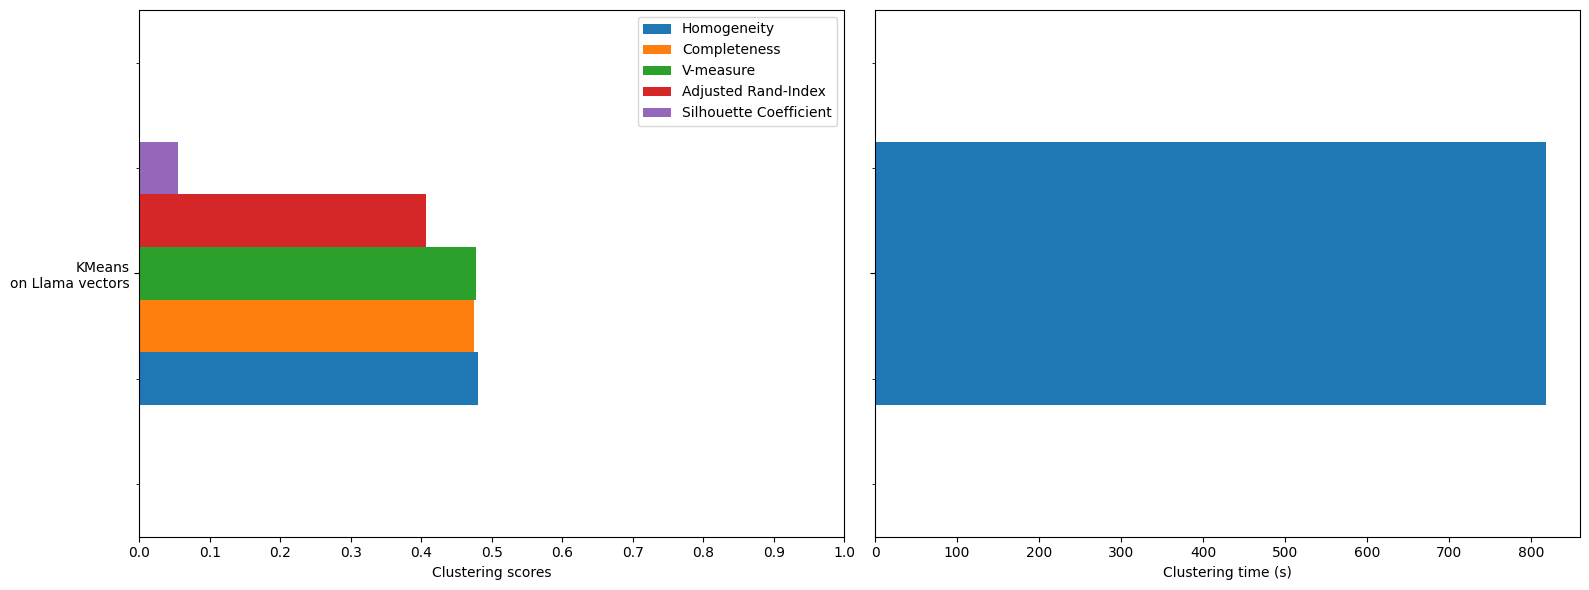

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans_three, embeddings_three, name="KMeans\non Llama vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

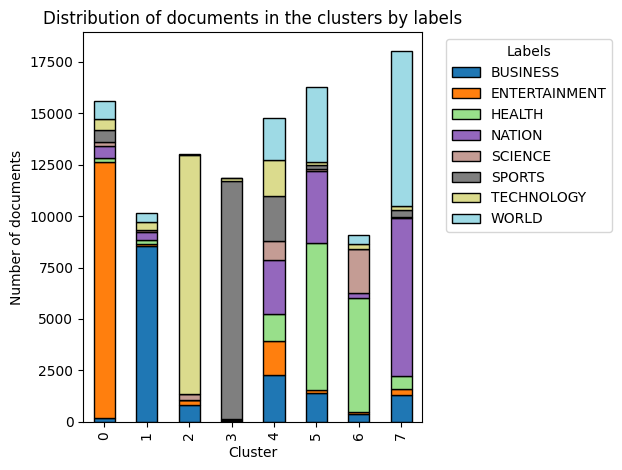

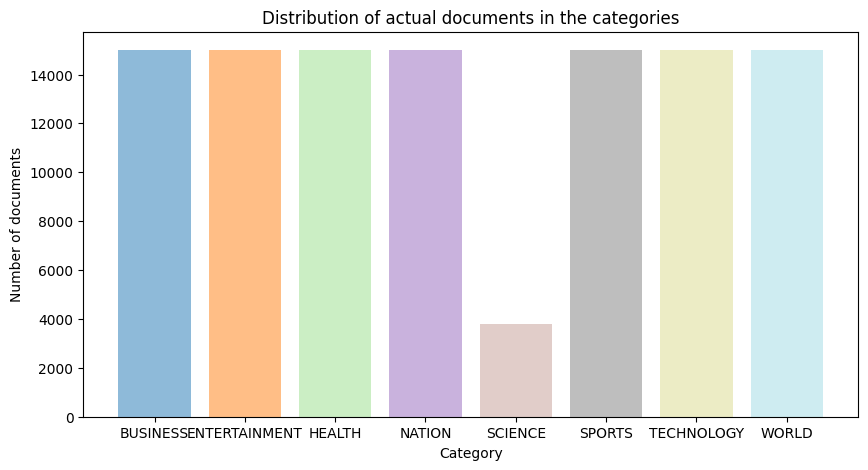


Distribution of documents in the clusters according to labels:
true_label  BUSINESS  ENTERTAINMENT  HEALTH  NATION  SCIENCE  SPORTS  \
cluster                                                                
0                204          12407     195     619      155     596   
1               8560             72     220     356       97      34   
2                809            238       7      12      267      42   
3                 20             92       8      19        2   11584   
4               2287           1660    1294    2607      949    2163   
5               1426            134    7113    3508       95     213   
6                403             69    5558     216     2152      15   
7               1291            328     605    7663       57     353   

true_label  TECHNOLOGY  WORLD  
cluster                        
0                  557    852  
1                  387    438  
2                11604     61  
3                  107     27  
4                 1746 

In [ ]:
x_labels = news_three_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_three_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes_three = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes_three)), category_sizes_three, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes_three)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_llama):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes_three):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_three_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_three_df[news_three_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the Llama 3 vectors of the documents in the current category.
        category_llama = embeddings_three[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_llama)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for SCIENCE: 0.5907344334715283
Average Cosine Similarity for TECHNOLOGY: 0.5734877258483899
Average Cosine Similarity for HEALTH: 0.6213451385647932
Average Cosine Similarity for WORLD: 0.6056502966864458
Average Cosine Similarity for ENTERTAINMENT: 0.618621045847501
Average Cosine Similarity for SPORTS: 0.6471682289930439
Average Cosine Similarity for BUSINESS: 0.5681249505522591
Average Cosine Similarity for NATION: 0.583385879058604


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_three_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_three_df[news_three_df['Category'] == category1].index
    category1_vector = embeddings_three[indices1]

    #Extract the documents in the second category
    indices2 = news_three_df[news_three_df['Category'] == category2].index
    category2_vector = embeddings_three[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between SCIENCE and TECHNOLOGY: 0.4913724660873413
Average Cosine Similarity between HEALTH and WORLD: 0.5753379464149475
Average Cosine Similarity between ENTERTAINMENT and SPORTS: 0.5728622674942017
Average Cosine Similarity between BUSINESS and NATION: 0.5255836248397827


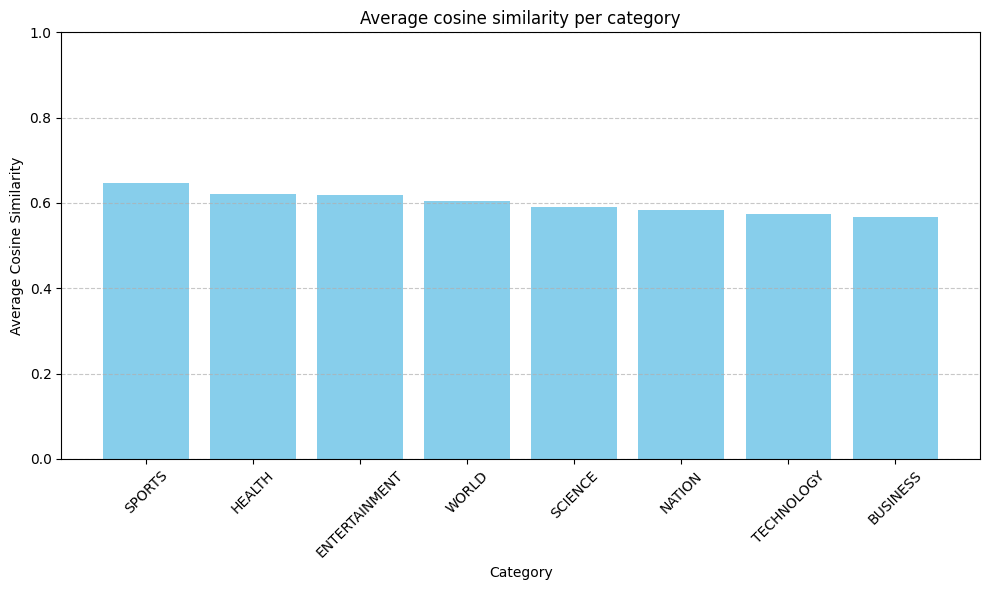

In [ ]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  #Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k_three):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans_three.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, embeddings_three)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

Here we create a heatmap which visually represents the top categories for each cluster based on the cosine similarity. The documents are sorted in descending order according to their similarity to the cluster center.

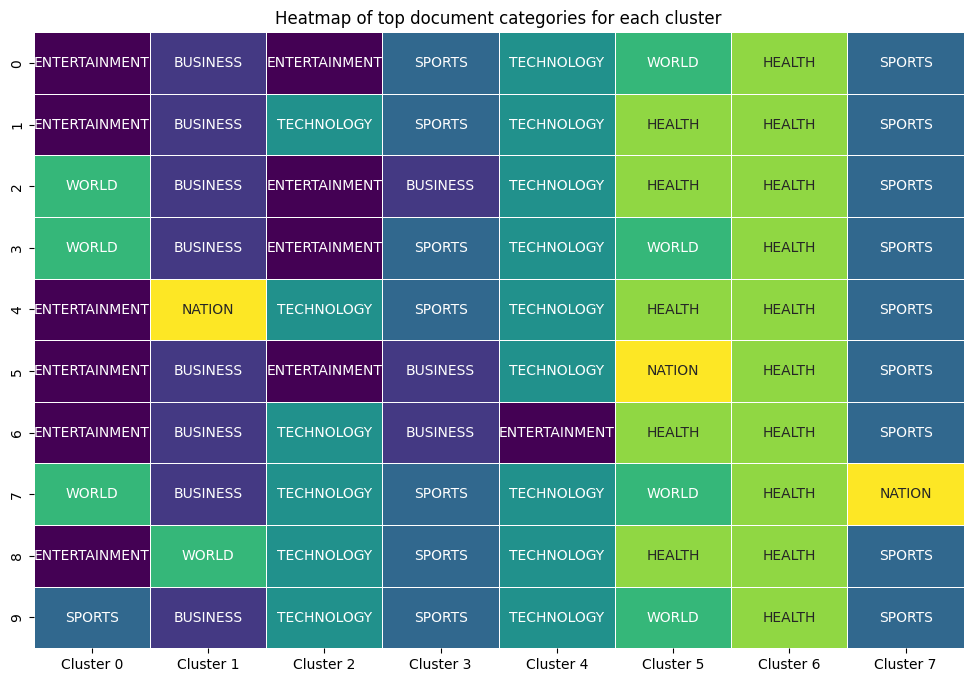

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_three_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)

#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k_three)])
heatmap_df = heatmap_df.T  # Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()


# **Sources**

The datasets,code, different methods and explanations are from these sources:

* https://www.kaggle.com/datasets/rafsunahmad/classify-news-into-category
* https://www.kaggle.com/datasets/setseries/news-category-dataset
* https://www.kaggle.com/datasets/kotartemiy/topic-labeled-news-dataset
* https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
*https://www.learndatasci.com/glossary/cosine-similarity/
* https://huggingface.co/meta-llama/Meta-Llama-3-8B
* https://llama.meta.com/llama3/
*https://ai.meta.com/blog/meta-llama-3/
*https://github.com/meta-llama/llama3
* ChatGPT to generate code and text
